In [173]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.signal as signal

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from itertools import product

import os
import fnmatch

# functions for KDE fits and GMM models

In [60]:
def get_peak_locations_from_KDE_fit(data, kde_bandwidth, find_peaks_wave_width_range, plot_range, plot=True):
    ''' Performs a KDE fit and then uses scipy.signal.find_peaks_cwt to get peaks.
        The KDE bandwith parameter is critical, and 0.025 seems appropriate for OD700 data that isn't very widely
        distributed (is only between 0 and 1). 
        If it feels like you are missing many peak calls, decrease the bandwith. If it feels
        like you are having too many peak calls, increase the bandwith. 
        
        Don't change the bandwith without good reason, but one bandwidth will not be appropriate for all data
        
        more discussion of bandwidth and kde found here:
            #explanation of what it is and what parameters exist
        https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28
        https://mathisonian.github.io/kde/
            #implementations
        https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
        
        
        Additionally, the widths given for the wavelets (i think) used in the wavelet convolution peak finder
        are critical as well, they should cover the approximate possible widths of your peaks. This is as critical
        as the bandwidth parameter in the kde and will affect the accuracy of peak finding. If your kde bandwidth
        produces a smooth enough kde function, you can probably just use a simpler function like scipy.signal.find_peaks
        that just finds all local maxima by comparing values. Haven't tested the simpler algorithm yet.
        
        '''
                        #critical param, fiddle with it to avoid oversmoothing (too large)
                        #or undersmoothing (too small) and just getting the distribution back
                        #think of this like adjusting histogram bin size
    kde = KernelDensity(bandwidth=kde_bandwidth, kernel='gaussian')

    kde.fit(data[:, None]);

    #no points in our OD700 data exceed value 1, so it is unnecessary to score values far outside of that
    #doing so will probably ruin your peak estimation
    x_est = plot_range

    log_dens = kde.score_samples(x_est[:,None])
    
    #Use the SciPy function to get the KDE peaks
                                                #critical param. if too small, will pick up "peaks" that are tiny or not
                                                #really there. If too large, will be very innacurate.
    peak_inds = signal.find_peaks_cwt(log_dens, find_peaks_wave_width_range, min_snr=1)

    means_init = []
    
    for peak_ind in peak_inds:
        means_init.append(x_est[peak_ind])
    
        #plot the KDE and peaks so you can check
    if plot==True:
        fig, ax = plt.subplots(figsize=(7,5))

        ax.plot(x_est, np.exp(log_dens), color='r', linewidth=3)
        ax.hist(data, density=True, color='purple');
        for m in means_init:
            ax.axvline(m, color='dodgerblue', linewidth=3, linestyle='-.')
        
    else:
        fig = None
    
    return means_init, fig, max(log_dens)

In [61]:
def fit_GMM_KDE(data, peaks): 
    """Generate a Gaussian mixture model from the output
    of a Gaussian Kernel Density Estimation. 
    
    Outputs the mean of the on peak, fraction on, mean of the off peak, 
    and fraction off. This version of the code assumes all cells not in the on peak are off!
    This is obviously only a good assumption for uni/bimodal data. If you have multimodal data,
    do not use this code."""
    
    #since you're passing a series instead of an array, convert to an array in format that Gaussian Mixture likes
    data_arr = data.values.reshape(len(data), 1)

    #peaks are passed as a list, so make them an array in proper format
    peaks = np.array(peaks).reshape(len(peaks), 1)
    
    #create the GMM with components equal to number of peaks found in your KDE fit, with initial means equal
    #to the peaks you founs
    opt_gmm = GaussianMixture(n_components = len(peaks) , means_init = peaks).fit(data_arr)  

    #built in method to predict the gaussian to which each data point belongs
    labels = opt_gmm.predict(data_arr)
    labels = np.ravel(labels.reshape(len(labels), 1))

    means = opt_gmm.means_
    
    #this df contains each measurement value and the gaussian it is associated with.
    #it also preserves the original index to you can put these assignments back into the full dataset
    #you can use this to pull out the measurements that fall into the desired gaussian for gating.
    df = pd.DataFrame({'value': np.ravel(data_arr), 'which_gaussian': labels})
    
    df['newindex'] = data.index
    df = df.set_index('newindex').rename_axis(None)
        
        
    return df, means

In [108]:
def assign_gmmpeak_kdefit (data, kde_bandwidth, find_peaks_wave_width_range, plot_range, ignore_peak_detect = False, show_plots=True):
    
    peaks, fig, max_log_dens = get_peak_locations_from_KDE_fit(data, kde_bandwidth, find_peaks_wave_width_range, plot_range, show_plots)
    
    if ignore_peak_detect:
        #in case the scipy peak detection isn't getting what you need, the GMM fitting is pretty good with whatever seed
        peaks = [0.0001, 0.6]
    
    assignment, new_means = fit_GMM_KDE(data, peaks)
    
    if show_plots == True:
        ax = fig.get_axes()[0]
        
        #just a list that should be too long so you can subsample it later. The number of peaks can't exceed this len
        colors = ['orange', 'g', 'b', 'gold']

        #put a vertical dashed line at the new mean after GMM fitting
        #put a rugplot color coded by the gaussian to which each value is assigned
        for i in range(len(new_means)):
            d = assignment.loc[assignment['which_gaussian'] == i, 'value']
            ax.eventplot(positions=d, color=colors[i], linelengths=np.exp(max_log_dens)/17, lineoffsets=0, linewidths=0.3)
            ax.axvline(new_means[i], color='k', linestyle = '--', linewidth=3)
            
        return assignment, new_means, peaks, fig

# find all the files you want to deal with

In [109]:
these = []
for root, dirs, files in os.walk('C:/Users/geeze/Box/biocircuits/Reed/projects/DARPA_biocon/Task 1.1/A+pTet-ccdA/20200710 capnresc 4 small ind sets/ind set 1/'):
    for f in files:
        if fnmatch.fnmatch(f, '*.xlsx'):
            name = os.path.realpath(os.path.join(root,f))
            these.append(name)

In [110]:
for_binning = these[-3:]

In [150]:
tpts = [2,3,5]

# get data

In [111]:
# directory = "C:/Users/geeze/Box/biocircuits/Reed/projects/DARPA_biocon/Task 1.1/A+pTet-ccdA/20200710 capnresc 4 small ind sets/ind set 1/raw t2 spots files/"

# filename = "20200821 cap n resc 4 set 1 v2 t2 spots.xlsx"

In [112]:
data = []
for file in for_binning:
    d = pd.read_excel(file, sheet_name='all_tidy')
    data.append(d)

In [113]:
#what measurement type are you looking at
meas = ['OD700', 'OD600']

## do the estimating and fitting for the measurements you just defined

In [114]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

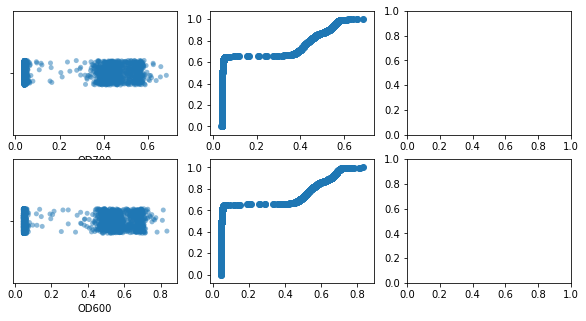

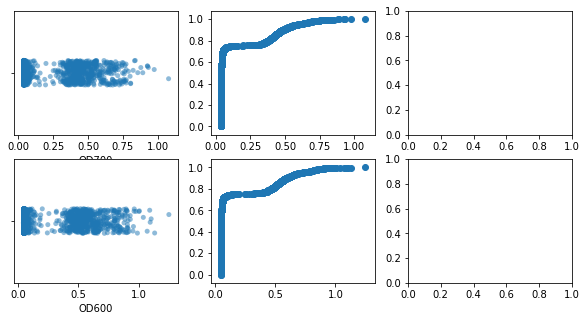

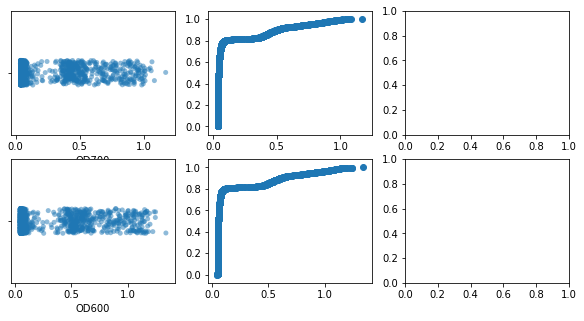

In [115]:
figs_for_later = []
for df in data:
    
    fig, axes = plt.subplots(len(meas), 3, figsize=(10,5)) #since we're doing 2 plot types, scatter and ECDF
    
    axes = np.ravel(axes)
    
    scatter_axes = axes[::3]
    ecdf_axes = axes[1::3]
    
    
    #how do the distributions look
    for m, ax in zip(meas, scatter_axes):
        sns.stripplot(x=df[m],  alpha = 0.5, ax=ax)
    for m, ax in zip(meas, ecdf_axes):
        x,y = ecdf(df[m])
        ax.scatter(x,y)
        
        
    figs_for_later.append(fig)

## do you see pretty clear demarcation of value+ areas and value- areas? if it's pretty clear, then you can probably proceed with the gaussian model fitting, it should classify everything ok

# do peak detection and labeling for OD data

In [116]:
#critical parameters for kde and peak detection, will vary depending on absolute values and distribution of data

#0.025 is small enough for data with low absolute value and relatively tight distribution (like OD700), but still smooths
kde_bandwidth = 0.025

#the range here should over the expected widths of your peaks
find_peaks_wavelet_width_range = np.arange(0.1, 0.5, step=0.1)

#decide the range of x values over which the log prob of the kde should be estimated
#this has to cover the range of the data
plot_range = np.linspace(0, 1, 500)

#DO YOU WANT TO IGNORE PEAK DETECTION AND JUST USE RANDOM SEED?
ignore_peaks = True

Number of peaks/gaussians/means GMM finds:  2 :  [[0.04140042]
 [0.45329977]]
[0 1]
Number of peaks/gaussians/means GMM finds:  2 :  [[0.04867979]
 [0.56683243]]
[0 1]
Number of peaks/gaussians/means GMM finds:  2 :  [[0.0411496 ]
 [0.38836918]]
[0 1]
Number of peaks/gaussians/means GMM finds:  2 :  [[0.04821698]
 [0.4699054 ]]
[0 1]
Number of peaks/gaussians/means GMM finds:  2 :  [[0.04524055]
 [0.47784285]]
[0 1]
Number of peaks/gaussians/means GMM finds:  2 :  [[0.17722321]
 [0.5962018 ]]
[0]


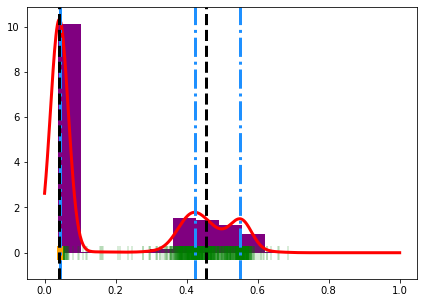

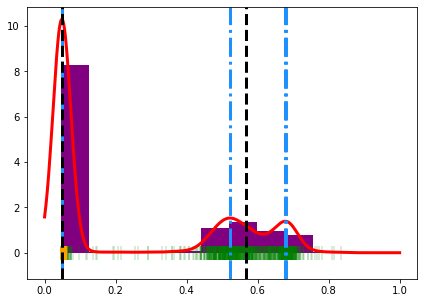

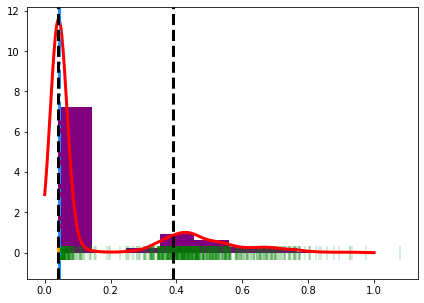

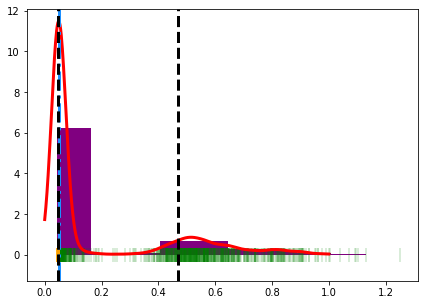

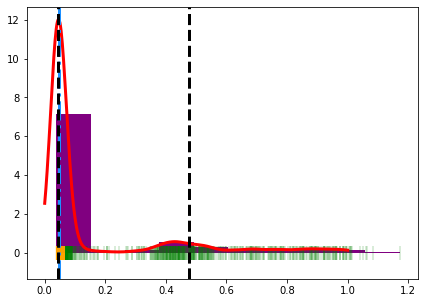

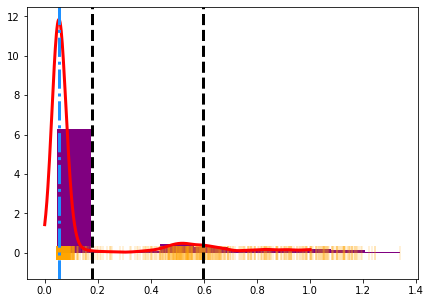

In [117]:
#i'm just going to work with OD700 data here
assignments = []
for df in data:
    ass_per_meas = []
    for m in meas:
        assignment, new_means, peaks, fig = assign_gmmpeak_kdefit(df[m], kde_bandwidth,
                                                                  find_peaks_wavelet_width_range, plot_range, ignore_peaks)

        print('Number of peaks/gaussians/means GMM finds: ', len(new_means), ': ', new_means)

        print(assignment['which_gaussian'].unique())
        
        ass_per_meas.append(assignment)
    
    assignments.append(ass_per_meas)

### pause, do you think the assignment pictured above is good? if so proceed, if not, adjust your params

In [132]:
#update the full dataset with your "gate" for counting. This will just update the indices run in this plate or 
#subsection of data you did. So this can be run iteratively to fill the dataset
labeled_data = []
for df, x in zip(data, assignments):
    for y, m in zip(x, meas):
        if 'which_gaussian' in df.columns:
            df.loc[y.index, ['value', 'which_gaussian']] = y[['value', 'which_gaussian']]
            df = df.drop(columns='value').rename(columns={'which_gaussian' : '{}_BULK_peak'.format(m)})
        else:
            #this will only happen once, before df has been updated at all
            df = df.join(y)
            df = df.drop(columns='value').rename(columns={'which_gaussian' : '{}_BULK_peak'.format(m)})
            
    labeled_data.append(df)

In [139]:
for df in labeled_data:
    df.rename(columns={'well' : 'exp_well'}, inplace=True)

## fluorescent channels (currently deprecated, do not use)

In [945]:
#what measurement type are you looking at
meas = 'YFP'

#sometimes it helps to od normalize fluor to get distributions nicer or easier to interpret
od_norm = False

In [946]:
#get just the measurement type you're working with
if od_norm:
    fl = sub[meas].replace('OVRFLW', 99999)  / sub['OD700']
else:
    fl = sub[meas].replace('OVRFLW', 99999)

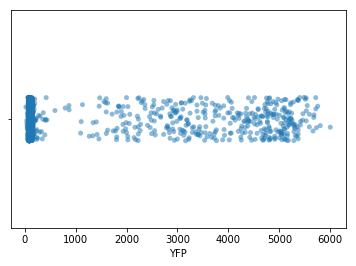

In [947]:
#how does the distribution look
ax = sns.stripplot(x=fl, alpha = 0.5)

In [948]:
#critical parameters for kde and peak detection, will vary depending on absolute values and distribution of data

#Fluor data has higher absolute values and needs a higher KDE bandwidth than OD700 so use 100
kde_bandwidth = 100

#the range here should over the expected widths of your peaks, see above to estiate
find_peaks_wavelet_width_range = np.arange(500, 5500, step=500)

#decide the range of x values over which the log prob of the kde should be estimated
#this has to cover the range of the data
high = 20000
plot_range = np.linspace(0, high, high)

#DO YOU WANT TO IGNORE PEAK DETECTION AND JUST USE RANDOM SEED?
ignore_peaks = True

C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Number of peaks/gaussians/means GMM finds:  2


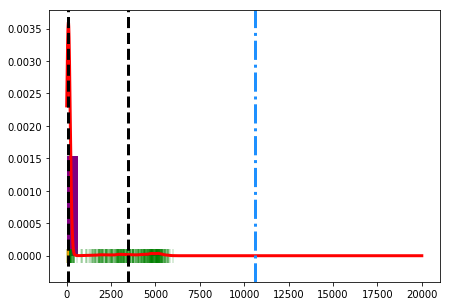

In [949]:
assignment, new_means, peaks, fig = assign_gmmpeak_kdefit(fl, kde_bandwidth,
                                                          find_peaks_wavelet_width_range, plot_range, ignore_peaks)

print('Number of peaks/gaussians/means GMM finds: ', len(new_means))

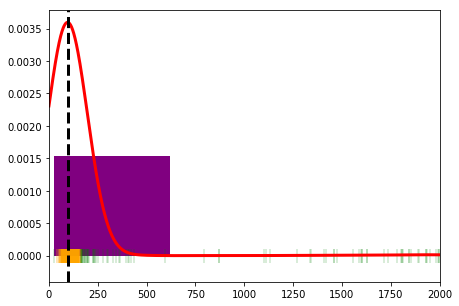

In [951]:
fig.get_axes()[0].set_xlim([0,2000])

fig

### pause, do you think the assignment pictured above is good? if so proceed, if not, adjust your params

In [952]:
#update the full dataset with your "gate" for counting. This will just update the indices run in this plate or 
#subsection of data you did. So this can be run iteratively to fill the dataset
if 'which_gaussian' in df.columns:
    df.loc[assignment.index, ['value', 'which_gaussian']] = assignment[['value', 'which_gaussian']]
else:
    #this will only happen once, before df has been updated at all
    df = df.join(assignment)

## reformat pretty

In [953]:
bulk = '_BULK' if everything == True else ''
    
norm = '/OD700' if od_norm == True else ''

df = df.drop(columns='value').rename(columns={'which_gaussian' : '{}{}{}_peak'.format(meas, norm, bulk)})

In [954]:
df.head()

,cell,row,col,time,dil,plate,OD700,CFP,YFP,RFP,OD700_peak,OD700_BULK_peak,RFP_BULK_peak,CFP_BULK_peak,YFP_BULK_peak
0,2c1r,A,1,0,10,1,0.401,2536,89,1406,0,0,0,1,0
1,2c1r,A,2,0,10,1,0.378,1838,91,1390,0,0,0,0,0
2,2c1r,A,3,0,10,1,0.634,32354,139,1662,1,1,0,1,0
3,2c1r,A,4,0,10,1,0.609,31674,135,1582,1,1,0,1,0
4,2c1r,A,5,0,10,1,0.593,28726,141,1729,1,1,0,1,0


## make sure very low values aren't called part of the upper gaussian

In [955]:
def single_thresh_line (df, col):
    #get the low assignments
    
    #just in case this isn't caught before. This should be caught during munging, but i made a mistake earlier and it
    # wasn't catching it
    df = df.replace('OVRFLW', 99999)
    
    i = df[col] == 0
    
    piece = df.loc[i]
    
    #what channel to look in to get max of the empty/off peak
    chan = col.split('_')[0]
    
    #get the highest empty/off labeled raw value
    max_val = max(piece[chan])
    
    #let's just work with the on-labeled assignments so we don't mess up the off ones
    #this shouldn't matter here, but with multimodal data it would matter more
    
    #high assignments
    high = df.loc[~i]
    
    #find the items in just the high assigned values you want to change
    change_these = high[chan] < max_val
    
    #now get their indices
    inds_to_change = high.loc[change_these].index
    
    #go back to the original data, use the indices to set the "mislabeled" high assigned values to low assignment
    df.loc[inds_to_change, col] = 0
    
    return df

In [956]:
f = [c for c in df.columns if '_peak' in c]
check = [x for x in f if 'FP' in x]

In [957]:
check

['RFP_BULK_peak', 'CFP_BULK_peak', 'YFP_BULK_peak']

In [958]:
for c in check:
    df = single_thresh_line(df, c)

# count peaks and determine fractions of empty wells

In [163]:
#this list contains the data that needs counting and converting to cfu
for_counting = these[-4:]

#time points these data represent, in order
tpts = [1,2,3,5]

data = []
for file in for_counting:
    d = pd.read_excel(file, sheet_name='all_tidy')
    data.append(d)

In [164]:
counted_data = []
for df in data:
    #these are the unique conditions over which I want to count
    exp_wells = df['exp_well'].unique()
    dils = df['dil'].unique()

    #enumerate combos
    wells_n_dils = list(product(exp_wells, dils))

    #measurements you want to use in this analysis
    channels_to_use = meas
    
    #now we do the counting
    frac_info = []
    for well, dil in wells_n_dils:
        #this assumes that each well receives the same dilution treatment without any absent conditions
        i1 = df['exp_well'] == well
        i2 = df['dil'] == dil

        i = i1 & i2

        sub = df.loc[i]

        inf = {"well" : well, "dil" : dil, "sample dil" : sub['sample dil'].unique()}

        for chan in channels_to_use:

            frac_empty = 1 - (sub['{}_BULK_peak'.format(chan)].sum() / len(sub['{}_BULK_peak'.format(chan)]))

            inf.update( {"{}_empty_frac".format(chan) : frac_empty} )

        frac_info.append(pd.DataFrame(inf))
        
        
        
    counted_data.append(pd.concat(frac_info).reset_index(drop=True))

In [166]:
for df, t in zip(counted_data, tpts):
    df['time'] = t

In [168]:
place = 'C:/Users/geeze/Box/biocircuits/Reed/projects/DARPA_biocon/Task 1.1/A+pTet-ccdA/20200710 capnresc 4 small ind sets/ind set 1/'
# pd.concat(counted_data).to_csv(place + 'non_zero_tpts_counted.csv', index=False)

## do the transformation to cfu/mL

In [220]:
# Import curve fitting package from scipy
from scipy.optimize import curve_fit

In [221]:
directory = "C:/Users/geeze/Box/biocircuits/Reed/projects/DARPA_biocon/Task 1.1/A+pTet-ccdA/20200710 capnresc 4 small ind sets/ind set 1/"

filename = "cfu.xlsx"

df = pd.read_excel(directory + filename)

In [222]:
df

,time,well,count,sample dil,dil,vol,cfu_counted,OD700_empty_frac,OD600_empty_frac
0,0,A4,84.0,4,1000,10.0,33600000.0,NaN,NaN
1,0,A4,13.0,4,10000,10.0,52000000.0,NaN,NaN
2,0,A5,82.0,4,1000,10.0,32800000.0,NaN,NaN
3,0,A5,12.0,4,10000,10.0,48000000.0,NaN,NaN
4,0,A5,2.0,4,100000,10.0,80000000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
219,5,D5,NaN,4,1280000,NaN,NaN,0.916667,1.0
220,5,D6,NaN,4,128000,NaN,NaN,0.583333,1.0
221,5,D6,NaN,4,384000,NaN,NaN,0.666667,1.0
222,5,D6,NaN,4,768000,NaN,NaN,0.520833,1.0


In [223]:
#define the function that we are using to tranform the data from probabilities to counts
def prob_empty (dil, lam):
    
    return np.exp((-lam) / dil)

## work with the echo data first

In [224]:
#just get the echo subset, you'll have to deal with the actually counted cfus different later
just_echo = df.dropna(how='any', axis = 'index', subset=['OD700_empty_frac'])

In [225]:
data = []

for t in just_echo['time'].unique():

    sub_time = just_echo[just_echo['time'] == t]

    for w in sub_time['well'].unique():
        d = sub_time[sub_time['well'] == w]

        #the calculated probability of empty well
        probs = d["OD700_empty_frac"].values


        #the actual dilutions from the sample
        dils = (d["dil"] * d["sample dil"]).values

        #fit your function with your data. You should compare bayesian methods and other optimization methods
        #you learned in bi 103, see your old hws
        pars, cov = curve_fit(f=prob_empty, xdata=dils, ydata=probs, p0=[0.5], bounds=(0, np.inf)) #must be positive number
        #pars is in units of (cells / 100nL)

        lam = (pars * 10**6) / 100 # 10^6 is the multiplication up to mL from nL, 100 is the total volume shot that needs dividing

        data.append((t, w, lam, cov))

In [226]:
#has everything but the actual counted cfu data
echo_df = pd.DataFrame(data, columns =['time', 'well', 'cfu', 'var'])

#the cfu values are arrays, the variance values are 2d arrays, break them down
echo_df['cfu'] = echo_df['cfu'].apply(lambda x: x[0])
echo_df['var'] = echo_df['var'].apply(lambda x: x[0][0])

## now the counted data

In [228]:
just_plate = df.dropna(how='any', axis = 'index', subset=['cfu_counted'])

In [232]:
data = []
t = 0
for w in just_plate['well'].unique():
    d = just_plate[just_plate['well'] == w]
    
    count = d['cfu_counted'].mean()
    var = d['cfu_counted'].var()
    
    data.append((t, w, count, var))

In [234]:
count_df = pd.DataFrame(data, columns =['time', 'well', 'cfu', 'var'])

# final save steps for everything

In [236]:
df = pd.concat([count_df, echo_df])

In [238]:
from openpyxl import load_workbook

path = directory + filename

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

df.to_excel(writer, sheet_name = 'cfu_final', index=False)


writer.save()
writer.close()